# Vector Space Word Embeddings

In this notebook, we build on the techniques we developed in the last module by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words,, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import time, logging, sys #For timing and logging

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For t-SNE
from sklearn.decomposition import PCA #For PCA
import spacy #For nlp
from gensim.test.utils import datapath #For analogy test


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

print(gensim.__version__)

4.3.0


## Getting our corpora

For a beginner, to build a word2vec model, all you need is a single text source. In the cells below, I will demonstrate how to combine texts from multiple text sources. Let's say that we want to combine all of the plays under the "../data/Shakespeare" and build a single model. 

In [2]:
targetDir = '../data/Shakespeare' 
shakespeare_texts = []
for file in os.listdir(targetDir):
    with open(targetDir + os.sep + file, 'r') as f:
        text = f.read()
    shakespeare_texts.append([file, text])
shakespeare_df = pandas.DataFrame(shakespeare_texts)
shakespeare_df.columns = ["filename", 'text']

We have basically read all of the texts into a dataframe where each cell in the "text" column is the full text of a play.

In [3]:
shakespeare_df

filename  \
0              julius_caesar.txt   
1             as_you_like_it.txt   
2                    tempest.txt   
3     phoenix_and_the_turtle.txt   
4                  king_lear.txt   
5         passionate_pilgrim.txt   
6                  cymbeline.txt   
7                 coriolanus.txt   
8    two_gentlemen_of_verona.txt   
9            rape_of_lucrece.txt   
10              king_henry_8.txt   
11          romeo_and_juliet.txt   
12        merchant_of_venice.txt   
13                   sonnets.txt   
14    anthonie_and_cleopatra.txt   
15    merry_wives_of_windsor.txt   
16                   othello.txt   
17    much_ado_about_nothing.txt   
18       taming_of_the_shrew.txt   
19              winters_tale.txt   
20   pericles_prince_of_tyre.txt   
21          comedy_of_errors.txt   
22           king_henry_4_p1.txt   
23           king_henry_4_p2.txt   
24           timon_of_athens.txt   
25           king_henry_6_p2.txt   
26  alls_well_that_ends_well.txt   
27           king_henry_6_p3.txt   
28           king_henry_6_p1.txt   
29          lovers_complaint.txt   
30          titus_andronicus.txt   
31              twelth_night.txt   
32         loves_labors_lost.txt   
33    midsummer_nights_dream.txt   
34              king_henry_5.txt   
35                 king_john.txt   
36                   macbeth.txt   
37      troilus_and_cressida.txt   
38          venus_and_adonis.txt   
39       measure_for_measure.txt   
40                    hamlet.txt   
41            king_richard_2.txt   
42            king_richard_3.txt   

                                                 text  
0   Dramatis Personae\n\n  JULIUS CAESAR, Roman st...  
1   AS YOU LIKE IT\n\nby William Shakespeare\n\n\n...  
2   The Tempest\n\nActus primus, Scena prima.\n\nA...  
3   THE PHOENIX AND THE TURTLE\n\nby William Shake...  
4   The Tragedie of King Lear\n\n\nActus Primus. S...  
5   THE PASSIONATE PILGRIM\n\nby William Shakespea...  
6   The Tragedie of Cymbeline\n\nActus Primus. Sco...  
7   THE TRAGEDY OF CORIOLANUS\n\nby William Shakes...  
8   THE TWO GENTLEMEN OF VERONA\n\nby William Shak...  
9   THE RAPE OF LUCRECE\n\nby William Shakespeare\...  
10  KING HENRY THE EIGHTH\n\nby William Shakespear...  
11  ROMEO AND JULIET\n\nby William Shakespeare\n\n...  
12  The Merchant of Venice\n\nActus primus.\n\nEnt...  
13  THE SONNETS\n\nby William Shakespeare\n\n\n\n ...  
14  The Tragedie of Anthonie, and Cleopatra\n\nAct...  
15  THE MERRY WIVES OF WINDSOR\n\nby William Shake...  
16  THE TRAGEDY OF OTHELLO, MOOR OF VENICE\n\nby W...  
17  MUCH ADO ABOUT NOTHING\n\nby William Shakspere...  
18  THE TAMING OF THE SHREW\n\nby William Shakespe...  
19  THE WINTER'S TALE\n\nby William Shakespeare\n\...  
20  PERICLES PRINCE OF TYRE\n\nby William Shakespe...  
21  DRAMATIS PERSONAE\n\nSOLINUS, Duke of Ephesus\...  
22  The First Part of Henry the Fourth\n\nwith the...  
23  KING HENRY IV, SECOND PART\n\nby William Shake...  
24  THE LIFE OF TIMON OF ATHENS\n\nby William Shak...  
25  The second Part of Henry the Sixt\n\nwith the ...  
26  All's Well, that Ends Well\n\nActus primus. Sc...  
27  The third Part of Henry the Sixt\n\nwith the d...  
28  Dramatis Personae\n\nKING HENRY the Sixth\nDUK...  
29  A LOVER'S COMPLAINT\n\nby William Shakespeare\...  
30  The Tragedie of Titus Andronicus\n\nActus Prim...  
31                               TWELFTH NIGHT;\n ...  
32  LOVE'S LABOUR'S LOST\n\nby William Shakespeare...  
33  A MIDSUMMER NIGHT'S DREAM\n\nby William Shakes...  
34  THE LIFE OF KING HENRY THE FIFTH\n\nby William...  
35  The life and death of King John\n\nActus Primu...  
36  MACBETH\n\nby William Shakespeare\n\n\n\n\nPer...  
37  THE HISTORY OF TROILUS AND CRESSIDA\n\nby Will...  
38  VENUS AND ADONIS\n\nby William Shakespeare\n\n...  
39  MEASURE FOR MEASURE\n\nby William Shakespeare\...  
40  The Tragedie of Hamlet\n\nActus Primus. Scoena...  
41  DRAMATIS PERSONAE\n\n  KING RICHARD THE SECOND...  
42  KING RICHARD III\n\nby Will

To learn the contextual information about each word, we need to first represent the text as a sequence of words. Because it is generally not a good idea to regard the last few words of a sentence and the first few words of the next setence as belonging to the same context, we want to first segment the text into sentences. We'll use spacy to perform the text. Let's take Hamlet as an example.

In [4]:
text = shakespeare_df.iloc[6]['text']
print(text[:300])

The Tragedie of Cymbeline

Actus Primus. Scoena Prima.

Enter two Gentlemen.

  1.Gent. You do not meet a man but Frownes.
Our bloods no more obey the Heauens
Then our Courtiers:
Still seeme, as do's the Kings

   2 Gent. But what's the matter?
  1. His daughter, and the heire of's kingdome (whom
He


In [5]:
# If you encounter an error, try to run the following line in your teminal: python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Notice that spacy performs sentence segmentation and word tokenization altogether.

In [6]:
for i in range(5):
    print(doc[i])

The
Tragedie
of
Cymbeline





In [7]:
doc_sents = [sent for sent in doc.sents]
print(doc_sents[2])

You do not meet a man but Frownes.



Next, we borrow and modify some useful tokenization functions from the last notebook. When bulding a word2vec model, we usually do not care about lemmitization. For simplicity, we also choose to exclude all stopwords. Depending on your need, you may or may not choose to turn all words into lower cases. Usually, when the corpus size is large enough, we can assume that word embeddings models will be able to learn syntatic similarities so that "kings" and "king" are similar in the learned vector space. But when the corpus size is relatively small or of a moderate size, we might want to provide more human assistance by lemmitzing "kings" to "king."

In [8]:
def word_tokenize(text, lower = True):
    tokenized = []
    # pass word list through language model
    if lower:
        text = text.lower()
    doc = nlp(text)
    for sent in doc.sents:
        tokenized_sentence = []
        for token in sent:
            if token.text != '\n'and not token.is_punct and len(token.text.strip()) > 0 and not token.is_stop:
                tokenized_sentence.append(token.text)
        tokenized.append(tokenized_sentence)
    return tokenized

In [9]:
tokenized_sentences = word_tokenize(text)

In [10]:
tokenized_sentences

[['tragedie', 'cymbeline', 'actus', 'primus'],
 ['scoena', 'prima', 'enter', 'gentlemen', '1.gent'],
 ['meet', 'man', 'frownes'],
 ['bloods', 'obey', 'heauens', 'courtiers', 'seeme', 'kings', '2', 'gent'],
 ['matter', '1'],
 ['daughter',
  'heire',
  'kingdome',
  "purpos'd",
  'wiues',
  'sole',
  'sonne',
  'widdow',
  'late',
  'married',
  'hath',
  "referr'd",
  'selfe',
  'vnto',
  'poore',
  'worthy',
  'gentleman'],
 ['wedded',
  'husband',
  "banish'd",
  "imprison'd",
  'outward',
  'sorrow',
  'thinke',
  'king',
  "touch'd",
  'heart',
  '2',
  'king',
  '1',
  'hath',
  'lost',
  'queene',
  "desir'd",
  'match'],
 ['courtier',
  'weare',
  'faces',
  'bent',
  'kings',
  'lookes',
  'hath',
  'heart',
  'glad',
  'thing',
  'scowle',
  '2',
  '1',
  'hath',
  "miss'd",
  'princesse',
  'thing',
  'bad',
  'bad',
  'report',
  'hath',
  'meane',
  'married',
  'alacke',
  'good',
  'man',
  "banish'd",
  'creature',
  'seeke',
  'regions',
  'earth',
  'like',
  'failing',

If you are only working with a single text, the list of lists we just produced would just be your input. Here, we want to combine all tokenized sentences into a single list of lists. We just apply the "tokenize" function to each text and then join them into a master list. Pandas' apply method is usaually faster than a for-loop. It will neverhtheless still run for a while. If you are working some gigantic corpora, you might want to parallelize the operations. When the computation is very costly, it is usually a good idea to test-run your code on a small piece of data first and record the time. 
The follow cell takes about 135 seconds to run on my computer. 

In [11]:
start = time.time()
shakespeare_df['tokenized_sents'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
end = time.time()
print(end-start)

159.73734712600708


The "tokenized_sents" column now contains the tokenized sentences of all the texts. 

In [12]:
shakespeare_df

filename  \
0              julius_caesar.txt   
1             as_you_like_it.txt   
2                    tempest.txt   
3     phoenix_and_the_turtle.txt   
4                  king_lear.txt   
5         passionate_pilgrim.txt   
6                  cymbeline.txt   
7                 coriolanus.txt   
8    two_gentlemen_of_verona.txt   
9            rape_of_lucrece.txt   
10              king_henry_8.txt   
11          romeo_and_juliet.txt   
12        merchant_of_venice.txt   
13                   sonnets.txt   
14    anthonie_and_cleopatra.txt   
15    merry_wives_of_windsor.txt   
16                   othello.txt   
17    much_ado_about_nothing.txt   
18       taming_of_the_shrew.txt   
19              winters_tale.txt   
20   pericles_prince_of_tyre.txt   
21          comedy_of_errors.txt   
22           king_henry_4_p1.txt   
23           king_henry_4_p2.txt   
24           timon_of_athens.txt   
25           king_henry_6_p2.txt   
26  alls_well_that_ends_well.txt   
27           king_henry_6_p3.txt   
28           king_henry_6_p1.txt   
29          lovers_complaint.txt   
30          titus_andronicus.txt   
31              twelth_night.txt   
32         loves_labors_lost.txt   
33    midsummer_nights_dream.txt   
34              king_henry_5.txt   
35                 king_john.txt   
36                   macbeth.txt   
37      troilus_and_cressida.txt   
38          venus_and_adonis.txt   
39       measure_for_measure.txt   
40                    hamlet.txt   
41            king_richard_2.txt   
42            king_richard_3.txt   

                                                 text  \
0   Dramatis Personae\n\n  JULIUS CAESAR, Roman st...   
1   AS YOU LIKE IT\n\nby William Shakespeare\n\n\n...   
2   The Tempest\n\nActus primus, Scena prima.\n\nA...   
3   THE PHOENIX AND THE TURTLE\n\nby William Shake...   
4   The Tragedie of King Lear\n\n\nActus Primus. S...   
5   THE PASSIONATE PILGRIM\n\nby William Shakespea...   
6   The Tragedie of Cymbeline\n\nActus Primus. Sco...   
7   THE TRAGEDY OF CORIOLANUS\n\nby William Shakes...   
8   THE TWO GENTLEMEN OF VERONA\n\nby William Shak...   
9   THE RAPE OF LUCRECE\n\nby William Shakespeare\...   
10  KING HENRY THE EIGHTH\n\nby William Shakespear...   
11  ROMEO AND JULIET\n\nby William Shakespeare\n\n...   
12  The Merchant of Venice\n\nActus primus.\n\nEnt...   
13  THE SONNETS\n\nby William Shakespeare\n\n\n\n ...   
14  The Tragedie of Anthonie, and Cleopatra\n\nAct...   
15  THE MERRY WIVES OF WINDSOR\n\nby William Shake...   
16  THE TRAGEDY OF OTHELLO, MOOR OF VENICE\n\nby W...   
17  MUCH ADO ABOUT NOTHING\n\nby William Shakspere...   
18  THE TAMING OF THE SHREW\n\nby William Shakespe...   
19  THE WINTER'S TALE\n\nby William Shakespeare\n\...   
20  PERICLES PRINCE OF TYRE\n\nby William Shakespe...   
21  DRAMATIS PERSONAE\n\nSOLINUS, Duke of Ephesus\...   
22  The First Part of Henry the Fourth\n\nwith the...   
23  KING HENRY IV, SECOND PART\n\nby William Shake...   
24  THE LIFE OF TIMON OF ATHENS\n\nby William Shak...   
25  The second Part of Henry the Sixt\n\nwith the ...   
26  All's Well, that Ends Well\n\nActus primus. Sc...   
27  The third Part of Henry the Sixt\n\nwith the d...   
28  Dramatis Personae\n\nKING HENRY the Sixth\nDUK...   
29  A LOVER'S COMPLAINT\n\nby William Shakespeare\...   
30  The Tragedie of Titus Andronicus\n\nActus Prim...   
31                               TWELFTH NIGHT;\n ...   
32  LOVE'S LABOUR'S LOST\n\nby William Shakespeare...   
33  A MIDSUMMER NIGHT'S DREAM\n\nby William Shakes...   
34  THE LIFE OF KING HENRY THE FIFTH\n\nby William...   
35  The life and death of King John\n\nActus Primu...   
36  MACBETH\n\nby William Shakespeare\n\n\n\n\nPer...   
37  THE HISTORY OF TROILUS AND CRESSIDA\n\nby Will...   
38  VENUS AND ADONIS\n\nby William Shakespeare\n\n...   
39  MEASURE FOR MEASURE\n\nby William Shakespeare\...   
40  The Tragedie of Hamlet\n\nActus Primus. Scoena...   
41  DRAMATIS PERSONAE\n\n  KING RICHARD THE S

The last step is to combine them into a single master list, which will be your word2vec imput.

In [13]:
shakespeare_tokenized_text = shakespeare_df['tokenized_sents'].sum()
shakespeare_tokenized_text[5000:5100]

[['thou', "be'st", 'poore', 'subiect', 'hee', 'king', 'thou', 'art', 'poore'],
 ['wouldst', 'thou', 'kent'],
 ['seruice', 'lear'],
 ['wouldst', 'thou', 'serue', 'kent'],
 ['lear'],
 ["do'st", 'thou', 'know', 'fellow', 'kent'],
 ['sir', 'haue', 'countenance', 'faine', 'master', 'lear'],
 ['kent'],
 ['authority', 'lear'],
 ['seruices', 'canst', 'thou', 'kent'],
 ['keepe',
  'honest',
  'counsaile',
  'ride',
  'run',
  'marre',
  'curious',
  'tale',
  'telling',
  'deliuer',
  'plaine',
  'message',
  'bluntly',
  'ordinary',
  'men',
  'fit',
  'quallified',
  'best',
  'dilligence',
  'lear'],
 ['old', 'art', 'thou', 'kent'],
 ['young', 'sir', 'loue', 'woman', 'singing', 'old', 'dote', 'thing'],
 ['haue', 'yeares', 'backe', 'lear'],
 ['follow',
  'thou',
  'shalt',
  'serue',
  'like',
  'thee',
  'worse',
  'dinner',
  'thee'],
 ['dinner', 'ho', 'dinner', 'knaue'],
 ['foole'],
 ['foole', 'hither'],
 ['sirrah', 'daughter', 'enter', 'steward'],
 ['ste'],
 ['you-', 'enter'],
 ['lear'],


## Another Example

We have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [14]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [15]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = pandas.concat([senReleasesDF, loadDir(senPath, senatorName)], ignore_index = True)

senReleasesDF[:100:10]

category                                           filePath  \
0   Klobuchar  ../data/grimmerPressReleases/Klobuchar/22May20...   
10  Klobuchar  ../data/grimmerPressReleases/Klobuchar/22Aug20...   
20  Klobuchar  ../data/grimmerPressReleases/Klobuchar/17Jul20...   
30  Klobuchar  ../data/grimmerPressReleases/Klobuchar/14Dec20...   
40  Klobuchar  ../data/grimmerPressReleases/Klobuchar/22Jan20...   
50  Klobuchar  ../data/grimmerPressReleases/Klobuchar/28May20...   
60  Klobuchar  ../data/grimmerPressReleases/Klobuchar/27Jun20...   
70  Klobuchar  ../data/grimmerPressReleases/Klobuchar/01Nov20...   
80  Klobuchar  ../data/grimmerPressReleases/Klobuchar/24Jan20...   
90  Klobuchar  ../data/grimmerPressReleases/Klobuchar/23Jan20...   

                                                 text  
0                                                 ...  
10                                                ...  
20                                                ...  
30                                                ...  
40                                                ...  
50                                                ...  
60                                                ...  
70                                                ...  
80                                                ...  
90                                                ...

In [16]:
senReleasesDF['text'][0]

'                                                                                                            Klobuchar Features Fergus Falls Bakery at    Minnesota Morning                                                                                                                                                                                                                                                                                                                                                   Serves treats from popular western Minnesota bakery                                                                                                                                                                                                                                                                                                                                                              May 22  2008 Washington  D C   Bakery goods from Falls Baking Company of Fergus Falls are

The Senator Release corus is even larger. Tokenizing all the press releases would require about 283 seconds on my computer. 

In [ ]:
#Apply our functions, notice each row is a list of lists now
start = time.time()
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: word_tokenize(x))
end = time.time()
print(end-start)
senReleasesDF[:100:10]

## Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. You may also want to tweak some hyper-parameters first. Here, we will run a skipgram model with 100 dimensions and negative sampling. 

It might also be a good idea to turn on logging to get a sense of what the algorithm is doing. 

In [ ]:
logging.basicConfig(stream=sys.stderr, level=logging.INFO)
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['tokenized_sents'].sum(), vector_size = 100, workers = 3, sg = 1, hs = 0, negative = 5)

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [ ]:
senReleasesW2V.wv['president'][:10] #Shortening because it's very large

If you want the full matrix, `.wv.vectors` stores all the vectors:

In [ ]:
senReleasesW2V.wv.vectors

Then, `index2word` lets you translate from the matrix to words:

In [ ]:
senReleasesW2V.wv.index_to_key[10]

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [ ]:
senReleasesW2V.wv.most_similar('president')

In [ ]:
senReleasesW2V.wv.most_similar('war')

Find which word least matches the others within a word set (cosine similarity):

In [ ]:
senReleasesW2V.wv.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [ ]:
senReleasesW2V.wv.most_similar(positive=['liberal','republican'], negative=['democrat'])

Word2vec is stochastic. Every time you build a model, you will get some slightly different results. The larger your traning corpus, the more stable the results will be. 

When the corpus is large, we would expect to see **liberal + republican - democrat = conservative**. In other words, in this dataset, **liberal** is to **democrat** as **conservative** is to **republican**. However, we are only using a sample of press releases in this demo. So, the results might be a bit noisy.

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

There are two common ways to visualize a word-embedding space in a 2d plot. Because the word-vectors are high-dimensional, whatevever way you use will result in some distortion. If your goal is to preserve the structural equivalence, PCA is the preferred method. On the other hand, if all you want to preserve is the relative proximity of words, then [t-SNE](https://lvdmaaten.github.io/tsne/) would do a better job. Here, we show how to map our word-vectors usikng t-SNE.

Let's focos on the top words in the corpus. Gensim by default sort the word-vectors according to the frequencies in the training corpus. So if we want to select the most frequent 50 words, we can just get the first 50 rows of the word-vectors.

In [ ]:
numWords = 50
targetWords = senReleasesW2V.wv.index_to_key[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

Then we can use T-SNE to project them down to two dimensions. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words. Note that t-SNE usually still uses PCA to produce a initial solutution. 

In [ ]:
tsneWords = sklearn.manifold.TSNE(n_components = 2, init = 'pca').fit_transform(wordsSubMatrix)

We now can plot the points

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``. Note that t-SNE should be solely used for visualization only. When you examine the geometric properties of word vectors, you would still want to perform as many operations in the high-dimensional space as possible.

## Working with pre-trained models

The example we demonstrated in the notebook is only a toy example. If you want to obtain a high-quality word-embedding spcace, you would like to train a word2vec model using a very large corpus. Depending on what your goal is, sometimes you can avoid the hastle by making use of a pre-trained model. Here, we will use a [pre-trained model](https://code.google.com/archive/p/word2vec/) originally produced by Tomas Mikolov, the guy who invented word2vec. It was trained on 100 billion words from a Google News dataset and contains 3 million word-vectors. The model is 1.5GB large. In order to make the following codes work, you will need to download the [model](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) yourself and specify the correct path. You will not want to read 3 million word-vectors on your personal computer because they will eat up all of your RAM. We'll use the "limit" parameter to specify that we'll only read the vector representations of the most frequent 100,000 words, which should suffice for most purposes.

In [ ]:
model_path = '../data/GoogleNews-vectors-negative300.bin'

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True, limit = 100000)  

Let's do some vector algebra. "king" + "woman" - "man" $\approx$ ?

In [ ]:
model.most_similar(positive=['king','woman'], negative=['man'])

In other words, "king" - "man" $\approx$ "queen" - "woman"
How about "Clinton" + "Republican" - "Democrat" $\approx$ ? Note that Mikoloc kept all captial letters. Why? Because he had a gigantic corpus and can afford to keep all variants.  

In [ ]:
model.most_similar(positive=['Clinton','Republican'], negative=['Democrat'])

'McCain' comes up as the top answer. Not a bad answer! But sometimes synonyms also come up as top answers, and you have to get rid of them in order to get the best counterparts. Mikolov was thoughtful enough to keep "Hillary_Clinton" as a separate word. If we substitute "Clinton" with "Hilary_Clinton," the top answers we get are actually all variants of her name. But if we exclude all these variants, the top answers are then "McCain" and "Condoleezza_Rice." Based on "Hilary_Clinton"'s contextual information, word2vec seems to have also learned the word's gender. 

In [ ]:
model.most_similar(positive=['Hillary_Clinton','Republican'], negative=['Democrat'])

How about "John_F._Kennedy" + "Republican" - "Democrat"  ≈ ?

In [ ]:
model.most_similar(positive=['John_F._Kennedy','Republican'], negative=['Democrat'])

After excluding 'JFK' and 'Kennedy", we havbe "Ronald_Reagan", 'Reagan," and "Richard_Nixon" as top answers. Again not bad! People have come up with various intuitive explanations of why vector algebra works. But nobody has been able to exactly tell why. The fact that one sometimes has to exclude synonyms (and certainly the focal word itself) in order to get the correct counterparts makes it still a mystery. 

Let's take a look at some gender stereotypes.

In [ ]:
model.most_similar(positive=['computer_programmer','woman'], negative=['man'])

If we want to capture the strucutral equivalence of words in a low-dimensional plot, then PCA would be the better projection modthod. We would need to first retrieve the corresponding word-vectors. Because we only care about the angular distances between words, we would normalize the length of all word_vectors(rows) to one and then perform PCA on the normalized row vectors. The following cell performs the job. 

In [ ]:
def rownorm(matrix):
    return np.apply_along_axis(np.linalg.norm, 1, matrix)

def normalize(matrix):
    return np.transpose(np.transpose(matrix) / rownorm(matrix))

vectors = model[['man','woman','king','queen']]
X = normalize(vectors)
pca = PCA(n_components = 2)
Y = pca.fit_transform(X)

Note again the operation is solely for the purpose of visualization.

In [ ]:
plt.plot(Y[[0,1],0],Y[[0,1],1])
plt.plot(Y[[2,3],0],Y[[2,3],1])
for i,word in enumerate(['man','woman','king','queen']):
    plt.text(Y[i,0],Y[i,1],word)

Let's try another example.

In [ ]:
words = ['France','Paris','Iraq','Baghdad', 'China', 'Beijing']
vectors = model[words]
X = normalize(vectors)
pca = PCA(n_components = 2)
Y = pca.fit_transform(X)
plt.plot(Y[[0,1],0],Y[[0,1],1])
plt.plot(Y[[2,3],0],Y[[2,3],1])
plt.plot(Y[[4,5],0],Y[[4,5],1])
for i,word in enumerate(words):
    plt.text(Y[i,0],Y[i,1],word)

## Analogy tests

How can we know whether a model is good or bad? The standard way of evaluating the quality of a word-embedding is to run a pre-specified list of analogy tests (such as "king" + "woman" - "man" $\approx$ ?) and see how many questions the model can get right. Here, we'll use the test quetsions that Mikolov used in his 2013 paper. The gensim package has a built-in fucntion for running the test.

In [ ]:
test_results = model.evaluate_word_analogies(datapath('questions-words.txt'))

We knew that the model we built from the press releases should be far inferior? How bad is it? Although your might still have the model in your RAM, to I will just load the one I saved ealier on to demonstrate how to do it. 

In [ ]:
senReleasesW2V = gensim.models.Word2Vec.load("senpressreleasesWORD2Vec")
press_release_test_results = senReleasesW2V.wv.evaluate_word_analogies(datapath('questions-words.txt'))

It only gets 3.7% of the answers right. It is really bad. Maybe hierarchical softmax works better for a small corpus? Let's re-train a model using hierarchical softmax.

In [ ]:
senReleasesW2V2 = gensim.models.word2vec.Word2Vec(senReleasesDF['tokenized_sents'].sum(), vector_size = 100, workers = 3, sg = 1, hs = 1, negative = 0)

In [ ]:
senReleasesW2V2.wv.evaluate_word_analogies(datapath('questions-words.txt'))

Yeah, it makes a slight improvement. Maybe. But it is still bad. So always try to increase your corpus size if you can. What if you don't have enough RAM and CPU power to train a good model? Try cloud computing. 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?
    
<span style="color:red">You may also run this exercise using some pre-trained models. For instance, you can find the [models](https://nlp.stanford.edu/projects/histwords/) that Jurafsky's team used in their PNAS study. The course instructor also has yearly models trained from the same Google Ngrams and can provide them upon request.

# Projection

The fact that we can perform vector algebra and obtain relationships such as "king" - "man" $\approx$ "queen" - "woman" suggests word-embeddings are capable of capturing some gender directions (dimensions.) Then, Kozlowski, Taddy & Evans (2019)'s paper suggests that we can project any word to such dimensions and obtain their gender scores. 
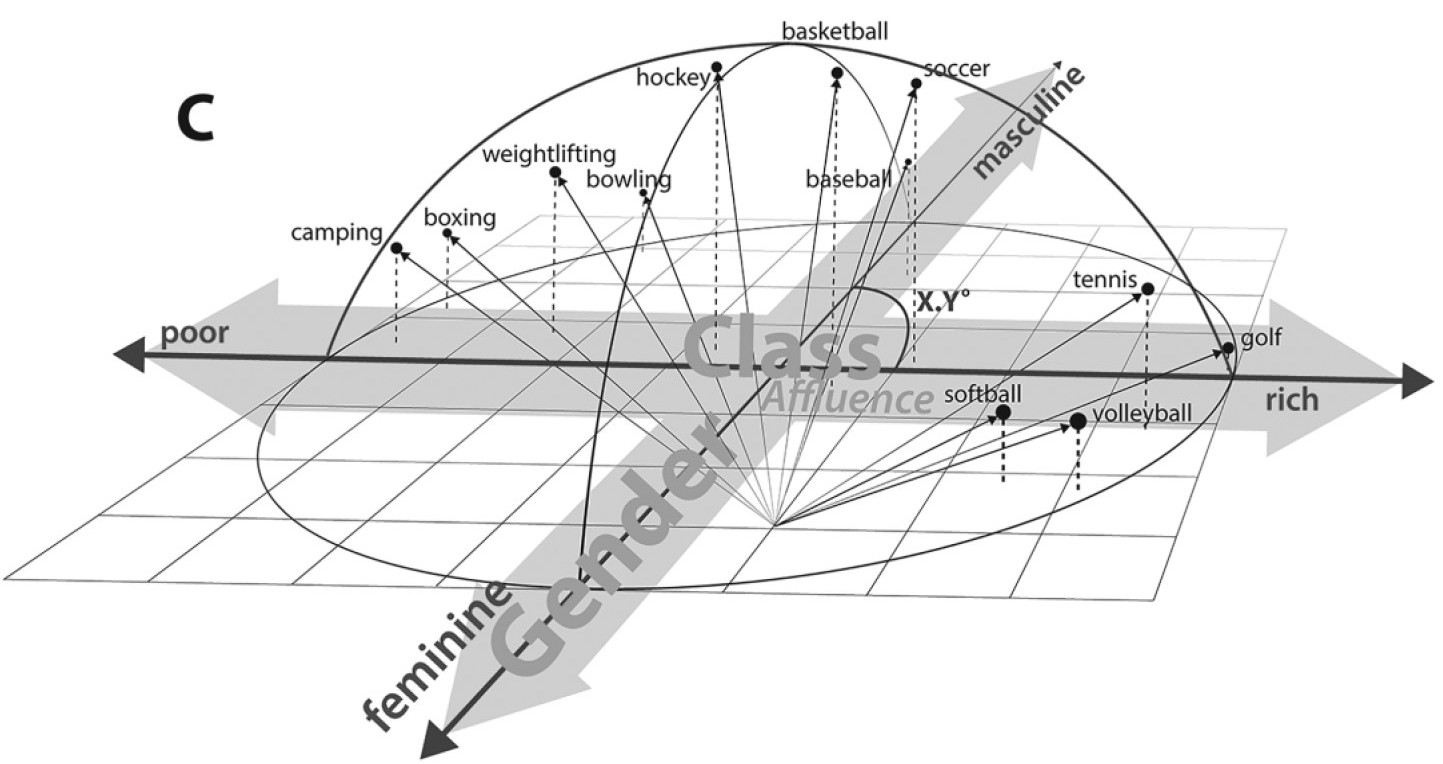

To demonstrate its utility, we will use a pre-trained CBOW model.

In [ ]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [ ]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [ ]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

In [ ]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [ ]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [ ]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [ ]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [ ]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

## Some Final Remarks

1. The gensim package is generally speaking fine-tuned already and does not require any additional tweaks to boost its performance. To train a word2vec model, all you need is a list of tokenized sentences. The default hyper-parameters seem to be good enough for most applications and do not need sinigicant adjustments. By default, it would build an 100-dimension skip-gram model using negative sampling with a context windows size of 5. Depending on your corpus size, you might want to adjust the dimension size or use hieararchical softmax. CBOW is generally much faster than skipgram, but the quality of the embedding it produces is also inferior. Sticking with skip-gram is usually the right choice. You might also want to check out this [Wikipedia article](https://en.wikipedia.org/wiki/Word2vec) for more insights about setting up the right parameters. 

2. Unlike PCA which always produces deterministic solutions, word2vec is a stochastic model. Every time you train a model using the same corpus, you will get a different word embedding. 

3. Although the angular distances between word-vectors are meaningful, their abosulute positions are meaningless and depend on random initialization. Any rotation of the same word embedding is equally good. 

4. In order to compare word embeddings trained from the same or different corpora, some alignment procedure might be needed. A common method for aligning two comparable word embeddings is [Procrusted Analysis](https://github.com/network-embeddings/temporal_embedding_matching). 

5. Since publishing the original *word2vec* model, Mikolov has introduced some interesting variants that are worth checking out:
   *  [*doc2vec*](https://radimrehurek.com/gensim/models/doc2vec.html): a sibling model of *word2vec* that does not only learn vector representation of words but also learns documents as context vectors in the same space. 
   *  [*FastText*](https://radimrehurek.com/gensim/models/fasttext.html): a word-embedding model that makes use of sub-word information to learn words as vectors. More precisely, it learns the vector representations of sub-word ngrams and represent composite words as the vector sum of its components. Research suggests that in comparison with word2vec, FastText is good at performing syntanctical analogy tests rather than semantic tests. 
   
